In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os import makedirs
from os.path import join, exists
from nilearn.plotting import plot_connectome, plot_roi, find_parcellation_cut_coords
import bct
import datetime
from nilearn.mass_univariate import permuted_ols
from scipy.stats import pearsonr, spearmanr
from sklearn.impute import KNNImputer

sns.set(context='poster', style='ticks')

In [2]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])
grays = sns.light_palette('#999999', n_colors=3, reverse=True)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

In [3]:
def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    # and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(
            alpha), 'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(
            alpha), 'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']
#subjects = ['101', '102']

data_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data'
sink_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output'
fig_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/figures/'

shen = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
craddock = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'
masks = ['shen2015', 'shen2015']

tasks = {'retr': [{'conditions': ['Physics', 'General']},
                  {'runs': [0, 1]}],
         'fci': [{'conditions': ['Physics', 'NonPhysics']},
                 {'runs': [0, 1, 2]}]}

sessions = [0, 1]
sesh = ['pre', 'post']
conds = ['high-level', 'lower-level']
iqs = ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']

index = pd.MultiIndex.from_product([subjects, sessions, tasks, conds, masks],
                                   names=['subject', 'session', 'task', 'condition', 'mask'])

In [5]:
big_df = pd.read_csv(join(data_dir, 
                          'rescored', 
                          'physics_learning-local_efficiency-BayesianImpute.csv'), 
                     index_col=0, header=0)

In [6]:
for iq in iqs:
    big_df['delta{0}'.format(iq)] = big_df['{0}2'.format(iq)] - big_df['{0}1'.format(iq)]
    big_df['delta{0}XSex'.format(iq)] = big_df['delta{0}'.format(iq)] * big_df['F']
    big_df['{0}2XSex'.format(iq)] = big_df['{0}2'.format(iq)] * big_df['F']
    big_df['delta{0}XClass'.format(iq)] = big_df['delta{0}'.format(iq)] * big_df['Mod']
    big_df['{0}2XClass'.format(iq)] = big_df['{0}2'.format(iq)] * big_df['Mod']
    big_df['SexXClass'] = big_df['F'] * big_df['Mod']
    big_df['delta{0}XSexXClass'.format(iq)] = big_df['delta{0}'.format(iq)] * big_df['SexXClass']
    big_df['{0}2XSexXClass'.format(iq)] = big_df['{0}2'.format(iq)] * big_df['SexXClass']

In [7]:
shen_nii = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
shen_coords = find_parcellation_cut_coords(labels_img=shen_nii)

crad_coords = find_parcellation_cut_coords(labels_img=shen)
coordinates = shen_coords

In [ ]:
alpha = 0.05

adj_a = 1 - (1 - alpha)**(1/8)
nloga = -np.log10(adj_a)

## First, we'll test connectivity during the physics knowledge task
We'll run the permuted OLS regressions with few permutations for a first pass look at how brain connectivity explains variance in different subscores of the WAIS. Significant regressions at this step will be re-run later with more permutations, for more accurate <i>p</i>- and <i>t</i>-values. This is a more efficient use of computational resources than running all possible regressions with many permutations right off the bat.

In [8]:
# read in every person's connectivity matrix (yikes)
# one task & condition at a time, I think. otherwise it becomes a memory issue
post_retr_conn = pd.DataFrame(columns=np.arange(0, 268**2))

for subject in subjects:
    try:
        corrmat = np.genfromtxt(join(sink_dir, 'corrmats', 
                                     #'{0}-session-1_retr-Physics_shen2015-corrmat.csv'.format(subject)),
                                     '{0}-session-1_retr-Physics_shen2015-corrmat.csv'.format(subject)),
                                delimiter=' ')
        post_retr_conn.at[subject] = np.ravel(corrmat, order='F')
    except Exception as e:
        print(subject, e)

213 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/corrmats/213-session-1_retr-Physics_shen2015-corrmat.csv not found.
217 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/corrmats/217-session-1_retr-Physics_shen2015-corrmat.csv not found.
322 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/corrmats/322-session-1_retr-Physics_shen2015-corrmat.csv not found.
329 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/corrmats/329-session-1_retr-Physics_shen2015-corrmat.csv not found.
332 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/corrmats/332-session-1_retr-Physics_shen2015-corrmat.csv not found.
452 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/corrmats/452-session-1_retr-Physics_shen2015-corrmat.csv not found.
456 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/corrmats/456-session-1_retr-Physics_shen2015-corrmat.csv not found.
457 /Users/kbottenh/Dropbox/Projects/physics-retrieval/

In [9]:
post_retr_conn.index = post_retr_conn.index.astype(int)

all_data = pd.concat([big_df, post_retr_conn], axis=1)
conns = list(set(post_retr_conn.columns))

brain_impute = KNNImputer(n_neighbors=10, weights='distance')
imp_conns = brain_impute.fit_transform(all_data.drop(['Sex', 'Class.Type'], axis=1))
imp_conn_df = pd.DataFrame(data=imp_conns, 
                           columns=all_data.drop(['Sex', 'Class.Type'], axis=1).columns, 
                           index=all_data.index)

imp_conn_df = imp_conn_df.astype('float')


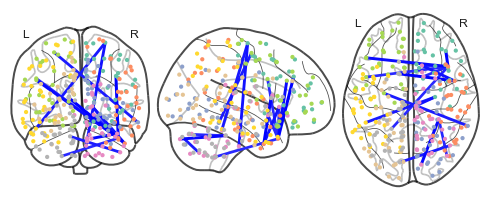

In [10]:
sig = {}
n_perm = 10000
retr_iqs = ['VCI2', 'WMI2', 'FSIQ2']

node_size = 5

for iq in retr_iqs:
    p, t, _ = permuted_ols(imp_conn_df['{0}'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}XSex'.format(iq),
                                        '{0}XClass'.format(iq),
                                        '{0}XSexXClass'.format(iq),
                                        'F', 'StrtLvl', 'SexXClass',
                                        'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=n_perm)
    sig['(IQ): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}-retr_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}-retr_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}-retr_phys-sig_edges_shen-t.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}-retr_phys-sig_edges_shen.png'.format(iq)), dpi=300)

    p, t, _ = permuted_ols(imp_conn_df['{0}XSex'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}'.format(iq),
                                     '{0}XClass'.format(iq),
                                     '{0}XSexXClass'.format(iq),
                                     'F', 'StrtLvl', 'SexXClass',
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=n_perm)
    sig['(IQXSex): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XSex-retr_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XSex-retr_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}XSex-retr_phys-sig_edges-t_shen.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}XSex-retr_phys-sig_edges_shen.png'.format(iq)), dpi=300)

    p, t, _ = permuted_ols(imp_conn_df['{0}XClass'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}'.format(iq),
                                     '{0}XSex'.format(iq),
                                     '{0}XSexXClass'.format(iq),
                                     'F', 'StrtLvl', 'SexXClass',
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=n_perm)

    sig['(IQXClass): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XClass-retr_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XClass-retr_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}XClass-retr_phys-sig_edges_shen-t.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}XClass-retr_phys-sig_edges_shen.png'.format(iq)), dpi=300)
    p, t, _ = permuted_ols(imp_conn_df['{0}XSexXClass'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}'.format(iq),
                                     '{0}XSex'.format(iq),
                                     '{0}XClass'.format(iq),
                                     'F', 'StrtLvl', 'SexXClass',
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=n_perm)
    sig['(IQXSexXClass): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XSexXClass-retr_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XSexXClass-retr_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}XSexXClass-retr_phys-sig_edges_shen-t.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}XSexXClass-retr_phys-sig_edges_shen.png'.format(iq)), dpi=300)

In [11]:
sig

{'(IQ): VCI2': 0.7983732476302812,
 '(IQXSex): VCI2': 0.5849030750809899,
 '(IQXClass): VCI2': 1.3429875744197588,
 '(IQXSexXClass): VCI2': 0.2646840942751519,
 '(IQ): WMI2': 1.1391068065767689,
 '(IQXSex): WMI2': 0.8788119721272413,
 '(IQXClass): WMI2': 0.9922956492761227,
 '(IQXSexXClass): WMI2': 1.116381992123245,
 '(IQ): FSIQ2': 1.1267228254614639,
 '(IQXSex): FSIQ2': 1.4078666698809958,
 '(IQXClass): FSIQ2': 0.8085924128119673,
 '(IQXSexXClass): FSIQ2': 2.853915391598625}

### For all significant OLS regressions, max p-value goes in a dataframe

In [12]:
sessions = ['post', 'delta']
variables = ['IQ', 'IQXSex', 'IQXClass', 'IQXSexXClass']
index = pd.MultiIndex.from_product([sessions, iqs])
significant = pd.DataFrame(index=index)
for key in sig.keys():
    if sig[key] >= 1.5:
        #print(key, sig[key])
        sig_keys = key.split(' ')
        sesh = sig_keys[0]
        iq = sig_keys[-1]
        variable = sig_keys[1].strip('():')
        significant.at[(sesh, iq), variable] = sig[key]

In [13]:
significant.to_csv(
    join(sink_dir, 'whole_brain-retr-permuted_ols-most_sig_pval-shen.csv'))
sig_keys = significant.dropna(how='all').index
print(sig_keys)

MultiIndex([('(IQXSexXClass):', 'FSIQ2')],
           )


In [14]:
keys = []
for i in np.arange(0, len(sig_keys)):
    if sig_keys[i][0] == 'post':
        keys.append(str(sig_keys[i][1] + '2'))
    if sig_keys[i][0] == 'delta':
        keys.append(str(sig_keys[i][0] + sig_keys[i][1]))

In [15]:
datetime.datetime.now().strftime("%H:%M:%S")

'10:09:53'

In [16]:
post_retr_conn = None

## And now we do it all over again for FCI

In [17]:
# read in every person's connectivity matrix (yikes)
# one task & condition at a time, I think. otherwise it becomes a memory issue
post_fci_conn = pd.DataFrame(columns=np.arange(0, 268**2))
errors = {}
for subject in subjects:
    try:
        corrmat = np.genfromtxt(join(sink_dir, 'corrmats', 
                                     #'{0}-session-1_fci-Physics_shen2015-corrmat.csv'.format(subject)),
                                     '{0}-session-1_fci-Physics_shen2015-corrmat.csv'.format(subject)),
                                delimiter=' ')
        post_fci_conn.at[subject] = np.ravel(corrmat, order='F')
    except Exception as e:
        errors[subject] = e
print(len(errors.keys()))

0
0
0
0
0
0
0
0
0
1
1
1
1
2
2
2
2
2
3
3
3
3
3
3
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
7
7
7
8
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
13
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19


In [18]:
post_fci_conn.index = post_fci_conn.index.astype(int)

all_data = pd.concat([big_df, post_fci_conn], axis=1)
conns = list(set(post_fci_conn.columns))

brain_impute = KNNImputer(n_neighbors=10, weights='distance')
imp_conns = brain_impute.fit_transform(all_data.drop(['Sex', 'Class.Type'], axis=1))
imp_conn_df = pd.DataFrame(data=imp_conns, 
                           columns=all_data.drop(['Sex', 'Class.Type'], axis=1).columns, 
                           index=all_data.index)

imp_conn_df = imp_conn_df.astype('float')


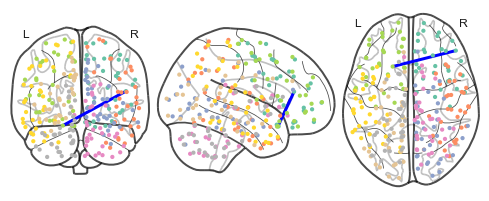

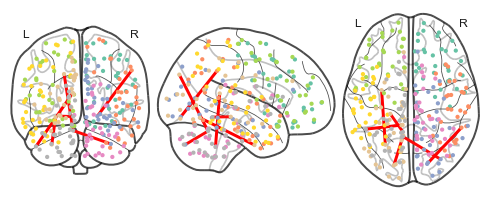

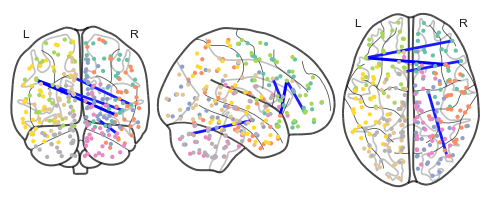

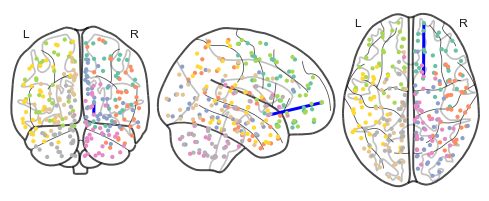

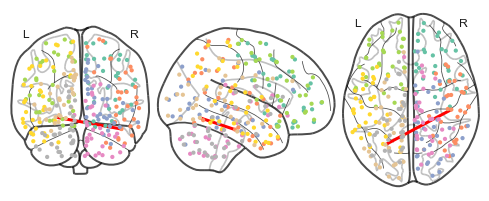

In [19]:
sig = {}
n_perm = 10000
fci_iqs = ['PRI2', 'FSIQ2', 'deltaPRI', 'deltaFSIQ']

print('adjusted alpha across ', nloga)

node_size = 5

for iq in fci_iqs:
    p, t, _ = permuted_ols(imp_conn_df['{0}'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}XSex'.format(iq),
                                     '{0}XClass'.format(iq),
                                     '{0}XSexXClass'.format(iq),
                                     'F', 'StrtLvl', 'SexXClass',
                                     'Age', 'Mod', 'post phys fci fd']].values,
                           n_perm=n_perm)
    sig['(IQ): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}-fci_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}-fci_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}-fci_phys-sig_edges_shen-t.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}-fci_phys-sig_edges_shen.png'.format(iq)), dpi=300)

    p, t, _ = permuted_ols(imp_conn_df['{0}XSex'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}'.format(iq),
                                     '{0}XClass'.format(iq),
                                     '{0}XSexXClass'.format(iq),
                                     'F', 'StrtLvl', 'SexXClass',
                                     'Age', 'Mod', 'post phys fci fd']].values,
                           n_perm=n_perm)
    sig['(IQXSex): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XSex-fci_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XSex-fci_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}XSex-fci_phys-sig_edges_shen-t.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}XSex-fci_phys-sig_edges_shen.png'.format(iq)), dpi=300)

    p, t, _ = permuted_ols(imp_conn_df['{0}XClass'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}'.format(iq),
                                     '{0}XSex'.format(iq),
                                     '{0}XSexXClass'.format(iq),
                                     'F', 'StrtLvl', 'SexXClass',
                                     'Age', 'Mod', 'post phys fci fd']].values,
                           n_perm=n_perm)

    sig['(IQXClass): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XClass-fci_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XClass-fci_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}XClass-fci_phys-sig_edges_shen-t.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}XClass-fci_phys-sig_edges_shen.png'.format(iq)), dpi=300)
    p, t, _ = permuted_ols(imp_conn_df['{0}XSexXClass'.format(iq)].values,
                           imp_conn_df[conns].values,
                           imp_conn_df[['{0}'.format(iq),
                                     '{0}XSex'.format(iq),
                                     '{0}XClass'.format(iq),
                                     'F', 'StrtLvl', 'SexXClass',
                                     'Age', 'Mod', 'post phys fci fd']].values,
                           n_perm=n_perm)
    sig['(IQXSexXClass): {0}'.format(iq)] = np.max(p)
    if np.max(p) > nloga:
        tmap = np.reshape(t, (268, 268), order='F')
        pmap = np.reshape(p, (268, 268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XSexXClass-fci_phys-tval_shen.csv'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(
            1, 269), index=np.arange(1, 269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XSexXClass-fci_phys-pval_shen.csv'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(
            join(sink_dir, '{0}XSexXClass-fci_phys-sig_edges_shen-t.csv'.format(iq)))

        q = plot_connectome(sig_edges, coordinates, node_size=node_size)
        q.savefig(
            join(fig_dir, '{0}XSexXClass-fci_phys-sig_edges_shen.png'.format(iq)), dpi=300)

In [20]:
sig

{'(IQ): PRI2': 0.6010623606187315,
 '(IQXSex): PRI2': 1.0110388115783258,
 '(IQXClass): PRI2': 0.3703280946297305,
 '(IQXSexXClass): PRI2': 1.6038440801811262,
 '(IQ): FSIQ2': 1.4559753829265871,
 '(IQXSex): FSIQ2': 1.841680935181613,
 '(IQXClass): FSIQ2': 1.4157122029093319,
 '(IQXSexXClass): FSIQ2': 2.6778241325429435,
 '(IQ): deltaPRI': 1.1959039949415122,
 '(IQXSex): deltaPRI': 0.7894574023717061,
 '(IQXClass): deltaPRI': 0.7122416973466367,
 '(IQXSexXClass): deltaPRI': 1.8570286270227676,
 '(IQ): deltaFSIQ': 1.388320119269521,
 '(IQXSex): deltaFSIQ': 1.6055917464506464,
 '(IQXClass): deltaFSIQ': 0.6663946707621615,
 '(IQXSexXClass): deltaFSIQ': 1.4535007637987316}

In [21]:
sessions = ['post', 'delta']
variables = ['IQ', 'IQXSex', 'IQXClass', 'IQXSexXClass']
index = pd.MultiIndex.from_product([sessions, iqs])
significant = pd.DataFrame(index=index)
for key in sig.keys():
    if sig[key] >= 1.5:
        #print(key, sig[key])
        sig_keys = key.split(' ')
        sesh = sig_keys[0]
        iq = sig_keys[-1]
        variable = sig_keys[1].strip('():')
        significant.at[(sesh, iq), variable] = sig[key]

In [27]:
significant.to_csv(
    join(sink_dir, 'whole_brain-fci-permuted_ols-most_sig_pval_shen.csv'))
sig_keys = significant.dropna(how='all').index
print(sig_keys)

MultiIndex([('(IQXSexXClass):',      'PRI2'),
            (      '(IQXSex):',     'FSIQ2'),
            ('(IQXSexXClass):',     'FSIQ2'),
            ('(IQXSexXClass):',  'deltaPRI'),
            (      '(IQXSex):', 'deltaFSIQ')],
           )


In [25]:
keys = []
for i in np.arange(0, len(sig_keys)):
    if sig_keys[i][0] == 'post':
        keys.append(str(sig_keys[i][1] + '2'))
    if sig_keys[i][0] == 'delta':
        keys.append(str(sig_keys[i][0] + sig_keys[0][1]))

In [26]:
keys

[]